In [1]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import httpagentparser

import pandas as pd
import numpy as np
import json

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/asharma/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from xgboost.sklearn import XGBClassifier
from ndcg import ndcg_scorer

In [4]:
!wc -l decodes01
!head -100000 decodes01 > smaller_decodes01
!wc -l smaller_decodes01

 3137627 decodes01
  100000 smaller_decodes01


###This training set size was chosen to prototype on the first iteration.

In [5]:
#grab the data
with open('smaller_decodes01', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df = pd.read_json(data_json_str)
df[:2]

,a,c,ckw,cy,dp,g,h,kw,mc,nk,pp,t,tz,u
0,Mozilla/5.0 (Linux; Android 4.4.2; GT-I9507 Bu...,AU,NaN,Perth,NaN,1H8wL5d,1H8wL5c,NaN,NaN,1,NaN,1427288399,Australia/West,http://www.airasia.com/au/en/promotion/rr05509...
1,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,US,NaN,Mountain View,NaN,1lj67KQ,1xupVE6,NaN,807,0,NaN,1427288399,America/Los_Angeles,https://cdn.adf.ly/js/display.js


###Swapping column names to something more friendly to humans :-)

In [6]:
column_map = {
    'h': 'Bitly user hash identifier',
    'g': 'Bitly global hash identifier',
    'a': 'browser user agent',
    'u': 'long URL',
    't': 'timestamp (UTC)',
    'c': 'country (two-letter code)',
    'nk': 'repeat client',
    'kw': 'keyword alias for user hash',
    'ckw': 'custom keyword',
    'cy': 'city (optional)',
    'tz': 'timezone',
}

#swapping out the spaces with underscores
column_map = {key: '_'.join(val.split()) for key, val in column_map.items()}

#convert it to a feature matrix
df_feature_M = df[column_map.keys()]

#convert the names
df_feature_M.rename(columns=column_map, inplace=True)
print 'new column names'
print '=' * 20
print '\n'.join(df_feature_M.columns)

new column names
browser_user_agent
country_(two-letter_code)
repeat_client
timezone
Bitly_global_hash_identifier
Bitly_user_hash_identifier
custom_keyword
city_(optional)
long_URL
timestamp_(UTC)
keyword_alias_for_user_hash


###Parsing the UA string

To parse the UA string I chose httpagentparser because it yielded the most homogenous results. There might be better libraries out there but for now we're sticking with this library.

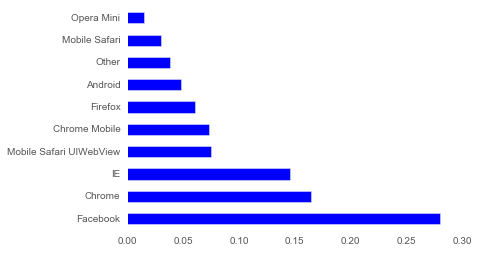

In [7]:
from user_agents import parse

def parse_for_browser(user_agent_str):
    user_agent = parse(user_agent_str)
    return user_agent.browser.family

df_del = df_feature_M.copy()
df_del['browser_type'] = df_del.browser_user_agent.apply(parse_for_browser)
df_del['browser_type'].value_counts(1)[:10].plot(kind='barh')

For this particular exercise Facebook should'nt be considered a valid type of browser and if we replace Facebook with Unknown we'll see that httpagentparser is best parser since it does a better job of finding the majority class. There's a much larger plot of the distribution below.

###Comparing the two parsers:

In [8]:
print 'user_agents'
print '-' * len('user_agents')
df_del['browser_type'].value_counts(1)[:10]

user_agents
-----------


Facebook                   0.28008
Chrome                     0.16473
IE                         0.14570
Mobile Safari UIWebView    0.07503
Chrome Mobile              0.07311
Firefox                    0.06083
Android                    0.04829
Other                      0.03849
Mobile Safari              0.02981
Opera Mini                 0.01509
Name: browser_type, dtype: float64

In [9]:
#Freeing up memory
df_del = None

In [10]:
def grab_browser_name(ua_str):
    browser = httpagentparser.detect(ua_str).get('browser')
    return browser['name'] if browser else 'Unknown'

df_feature_M['browser_type'] = df_feature_M.browser_user_agent.apply(grab_browser_name)
print 'httpagentparser'
print '-' * len('httpagentparser')
df_feature_M['browser_type'].value_counts(1)[:10]

httpagentparser
---------------


Chrome                         0.34583
Unknown                        0.25578
Microsoft Internet Explorer    0.16125
AndroidBrowser                 0.09741
Firefox                        0.06254
Safari                         0.04893
Opera                          0.02095
UCBrowser                      0.00383
ChromeiOS                      0.00114
GoogleBot                      0.00061
Name: browser_type, dtype: float64

##Making a quick hash map with users as keys and browsers as values

Dummytizing the top X users and using a hash table to lookup thier browser would be a smart thing to do but that doesn't seem necessary if we know we have the UA string and we're just trying to classify the 'other'/'unknown' types of browsers. On a side note, I did a quick check and noticed one the user aliases had several browsers associated with thier hash.

''

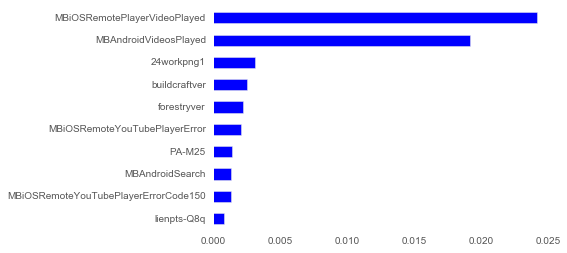

In [11]:
# if there's a browser type clearly identified w the user, it should be stored with the key/hash
# bar charts of user_hash_tags vs unique_user hashtags

df_feature_M.keyword_alias_for_user_hash.value_counts(1)[:10][::-1].plot(kind='barh')
;

As an example this hash '24workpng1' seems to apply to many different browsers

In [12]:
mask = df_feature_M.keyword_alias_for_user_hash == '24workpng1' 
print '\n'.join(df_feature_M[mask].browser_type.unique())

Chrome
Microsoft Internet Explorer
Firefox
AndroidBrowser
Opera
Safari
GoogleBot
Unknown
NokiaOvi


In [13]:
drop_of_interest = [
    'browser_user_agent',
    'Bitly_user_hash_identifier',
    'long_URL',
    'keyword_alias_for_user_hash',
    'custom_keyword',
    'city_(optional)',
    'Bitly_global_hash_identifier',
    'timestamp_(UTC)',
    'country_(two-letter_code)',
    'new',
    'timezone'
    ]

In [14]:
df_feature_M.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
browser_user_agent              100000 non-null object
country_(two-letter_code)       99638 non-null object
repeat_client                   100000 non-null int64
timezone                        90672 non-null object
Bitly_global_hash_identifier    100000 non-null object
Bitly_user_hash_identifier      100000 non-null object
custom_keyword                  301 non-null object
city_(optional)                 79391 non-null object
long_URL                        100000 non-null object
timestamp_(UTC)                 100000 non-null int64
keyword_alias_for_user_hash     12778 non-null object
browser_type                    100000 non-null object
dtypes: int64(2), object(10)
memory usage: 9.9+ MB


##Feature Engineering

I thought there might have been some signal in the existence of a user alias or custom keyword. Only one way to check! So I'm just making some dummy variables to check whether or not an alias exists.

In [15]:
#boolean if it exist or not
df_feature_M['new_custom_keyword'] = df_feature_M.custom_keyword.isnull()
df_feature_M['new_custom_keyword'][:5]

0    True
1    True
2    True
3    True
4    True
Name: new_custom_keyword, dtype: bool

In [16]:
#boolean if it exist or not
df_feature_M['new_keyword_alias_for_user_hash'] = df_feature_M.keyword_alias_for_user_hash.isnull()
df_feature_M['new_keyword_alias_for_user_hash'][:5]

0     True
1     True
2     True
3     True
4    False
Name: new_keyword_alias_for_user_hash, dtype: bool

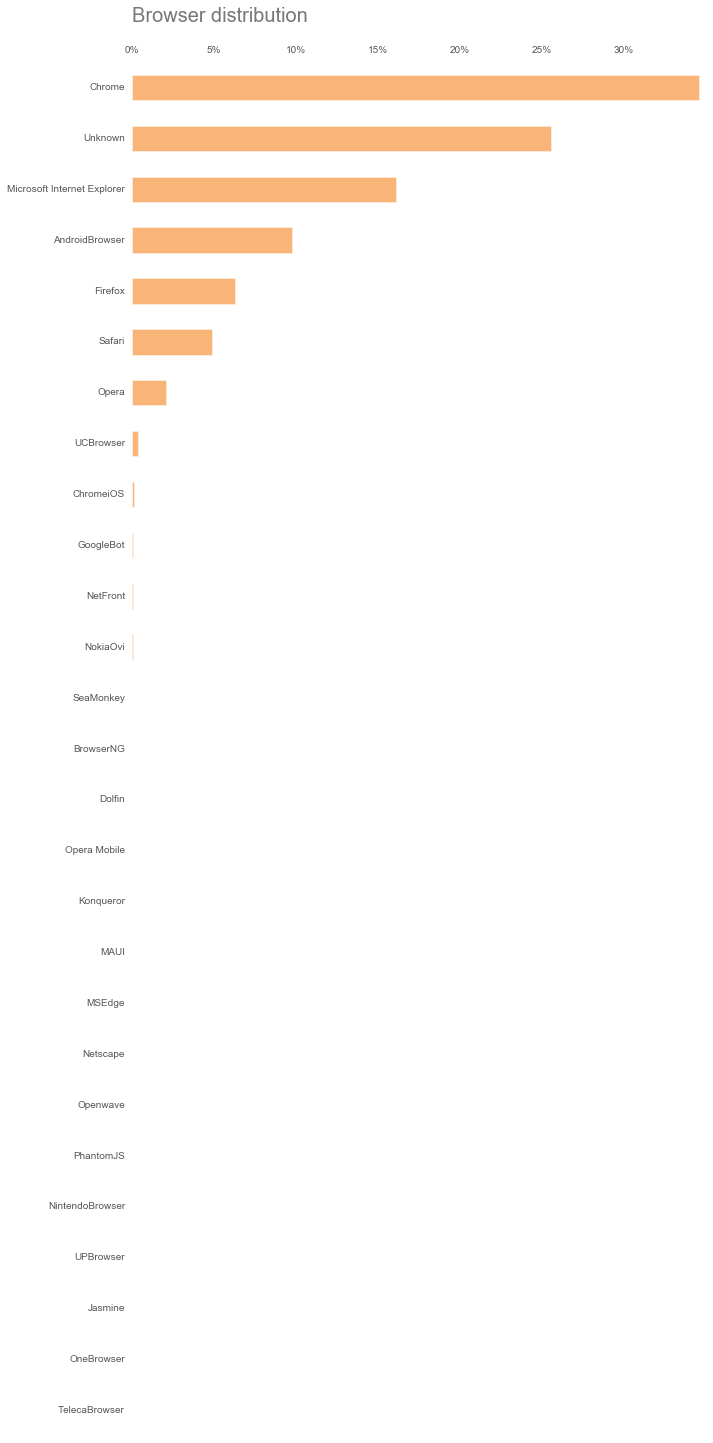

In [17]:
def plot_dist(df_to_plot, series_name, lab):
    '''    
    INPUT: DF, name of the column or series, label for the x-axis
    OUTPUT: distribution of violation codes sorted by popularity (Bar Chart)
    '''

    # create a figure of given size
    fig = plt.figure(figsize=(10,20))

    # add a subplot
    ax = fig.add_subplot(111)
    
    # set color transparency (0: transparent; 1: solid)
    a = 0.8

    # set x axis label on top of plot, set label text
    ax.xaxis.set_label_position('bottom')
    xlab = lab
    ax.set_xlabel(xlab, fontsize=20, alpha=a, ha='left')
    ax.xaxis.set_label_coords(0, 1.04)

    # position x tick labels on top
    ax.xaxis.tick_top()

    # remove tick lines in x and y axes
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    # remove grid lines (dotted lines inside plot)
    ax.grid(False)

    # remove plot frame
    ax.set_frame_on(False)

    # labeling 
    labels = df_to_plot[series_name].value_counts().index
    labels_cnv = [str(labels[i]) for i, acct in enumerate(labels)]

    # using the actual data to plot
    value_count_series = df_to_plot[series_name].value_counts(1)[::-1] * 100
    value_count_series.plot(
    ax=ax, 
    kind='barh', 
    color=(0.9698, 0.6378, 0.3373), 
    alpha=a, 
    edgecolor='w',
    )
    
    # multiply xticks by format into pct
    fmt = '%.0f%%' # Format for the ticks, e.g. '40%'
    xticks = matplotlib.ticker.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    ax.xaxis.set_ticks(ax.xaxis.get_majorticklocs()[:-1])

    
    plt.tight_layout()
    plt.show()
    ;

#shorten up the spacing for this
plot_dist(df_feature_M, 'browser_type', 'Browser distribution')

###What are the top 6 browsers?

In [18]:
#note: 'Unknown' is about 25%
#what are the top 5 browsers?

top_6_browsers = df_feature_M.browser_type.value_counts().index[::-1][-6:]
print '\n'.join(df_feature_M.browser_type.value_counts().index[-6:])

PhantomJS
NintendoBrowser
UPBrowser
Jasmine
OneBrowser
TelecaBrowser


In [19]:
map_misc_browser = {
    'NetFront': 'misc',
    'SeaMonkey': 'misc',
    'NokiaOvi': 'misc',
    'BrowserNG': 'misc',
    'OperaMobile': 'misc',
    'Dolfin': 'misc',
    'MAUI': 'misc',
    'Openwave': 'misc',
    'PhantomJS': 'misc',
    'MSEdge': 'misc',
    'TelecaBrowser': 'misc',
    'UPBrowser': 'misc',
    'Konqueror': 'misc',
    'Jasmine': 'misc',
    'NintendoBrowser': 'misc',
}

df_feature_M.browser_type = df_feature_M.browser_type.apply(lambda x: map_misc_browser.get(x) if map_misc_browser.get(x) else x)

In [20]:
def plot_hourly_histograms(df, date_time_field='timestamp_(UTC)', convert_to_this_tz_field='timezone', ax_index=None, plot_title=None):
    from pytz import timezone
    
    if 'datetime' not in str(df_feature_M['timestamp_(UTC)'].dtype):
        df[date_time_field] = pd.DatetimeIndex (df[date_time_field].astype('datetime64[s]'))

    #this needs to be refactored to something that's optimized for numpy arrays
    lis = []    
    for stamp, zone in df[[date_time_field, 'timezone']].values:
        try:
            lis.append(timezone(zone).localize(stamp))
        except AttributeError:
            lis.append(np.nan)


    df['new'] = pd.Series(lis)
    df['hour'] = pd.DatetimeIndex(df['new']).hour

    if ax_index:
        #remove the y_labels
        df.hour.plot(kind='hist',bins=24, ax=axes[ax_index[0]][ax_index[1]], title=plot_title)
    else:
        #df['N'].hist(by=df['Letter']) won't work here
        df_feature_M.hour.plot(kind='hist',bins=24,  title=plot_title)
    pass



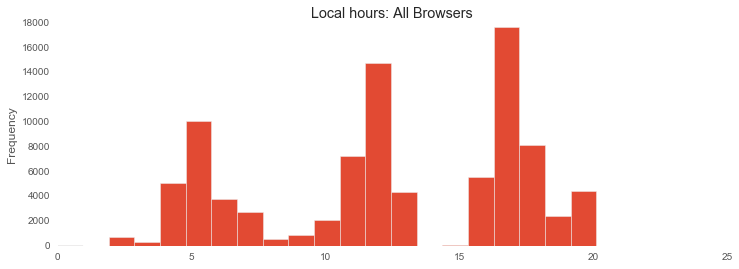

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

plot_hourly_histograms(df_feature_M, plot_title='Local hours: All Browsers')

''

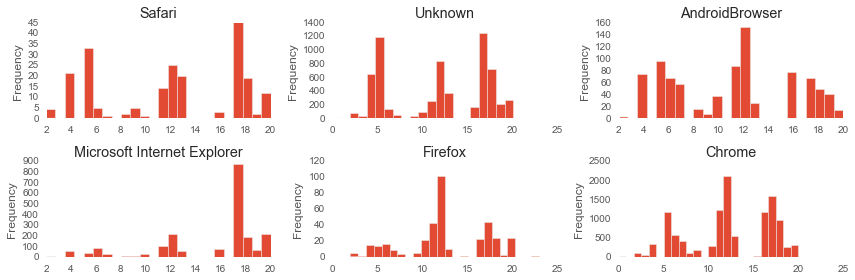

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 4))

for i, browser in enumerate(top_6_browsers):
    plot_hourly_histograms(df_feature_M[df_feature_M.browser_type == browser], ax_index=(i % 2, i % 3), plot_title=browser)

plt.tight_layout()
;

In [23]:
def df_to_perc_breakouts_per_country(input_df):
    '''
    INPUT: DF with each restuarant and grade listed (Raw Data)
    OUTPUT: DF with percentage composition by cuisine type
    '''
    output_df = input_df[['country_(two-letter_code)','browser_type']].groupby('country_(two-letter_code)').count()

    #function used to normalize grades by percentage
    perc_computation_function = \
    lambda x: x[x['browser_type'] == str(letter)].count() / x['browser_type'].count()

    for letter in input_df['browser_type'].unique():
        temp_df = input_df.groupby('country_(two-letter_code)')
        temp_df = temp_df.apply(perc_computation_function)
        output_df[str(letter)] = temp_df['browser_type']    

    return output_df

df_countries_stratified_by_browser_type = df_to_perc_breakouts_per_country(df_feature_M)
df_countries_stratified_by_browser_type[:5]

,browser_type,Chrome,Microsoft Internet Explorer,Unknown,Safari,Firefox,AndroidBrowser,Opera,misc,UCBrowser,ChromeiOS,Opera Mobile,GoogleBot,Netscape,OneBrowser
country_(two-letter_code),,,,,,,,,,,,,,,
A1,139,0.050360,0.122302,0.014388,0.014388,0.510791,0.000000,0.057554,0.014388,0.215827,0,0,0,0,0
A2,130,0.000000,0.015385,0.007692,0.000000,0.584615,0.030769,0.046154,0.000000,0.315385,0,0,0,0,0
AD,7,0.285714,0.000000,0.285714,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,0,0,0,0,0
AE,354,0.440678,0.076271,0.231638,0.062147,0.028249,0.149718,0.005650,0.000000,0.005650,0,0,0,0,0
AF,10,0.400000,0.000000,0.000000,0.000000,0.200000,0.400000,0.000000,0.000000,0.000000,0,0,0,0,0


In [24]:
import pycountry

# convert names of countries
def convert_country_codes_index(df):
    new_idx = {country_code: pycountry.countries.get(alpha2=country_code).name for country_code in df.index}
    return df.rename(index=new_idx)

##Top Countries

the top 20 countries comprise ~78.5% of the activity. Not surprisingly, US seem users seems to have the largest user-base. What's interesting is that Taiwan is a runner up and Brazil right after -- would'nt have guessed! 

0.78466


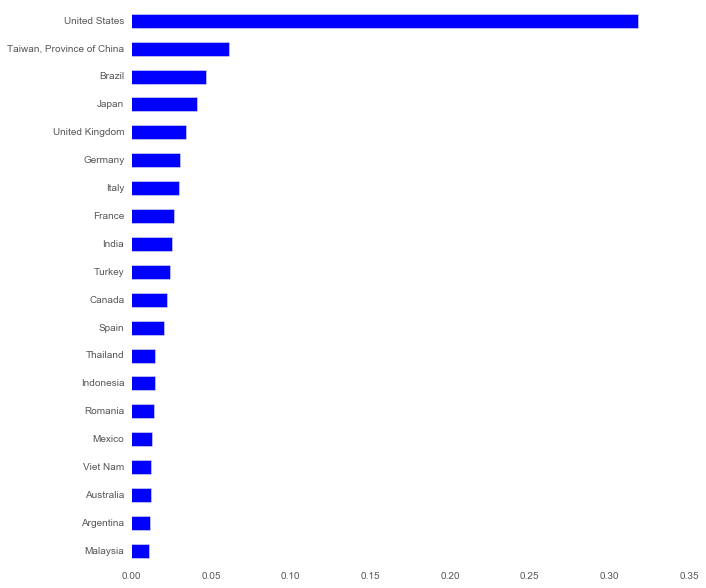

In [25]:
top_x = 20
countries_barchart = df_feature_M['country_(two-letter_code)'].value_counts(1)[:top_x][::-1]
top_x_countries = countries_barchart.index
countries_barchart_encoded = convert_country_codes_index(countries_barchart)
countries_barchart_encoded.plot(kind='barh', figsize=(10,10))
print countries_barchart_encoded.sum()

Note the gaps in the barchart are made because we're only limited to the top 6 browsers so not everythign sums to 100%

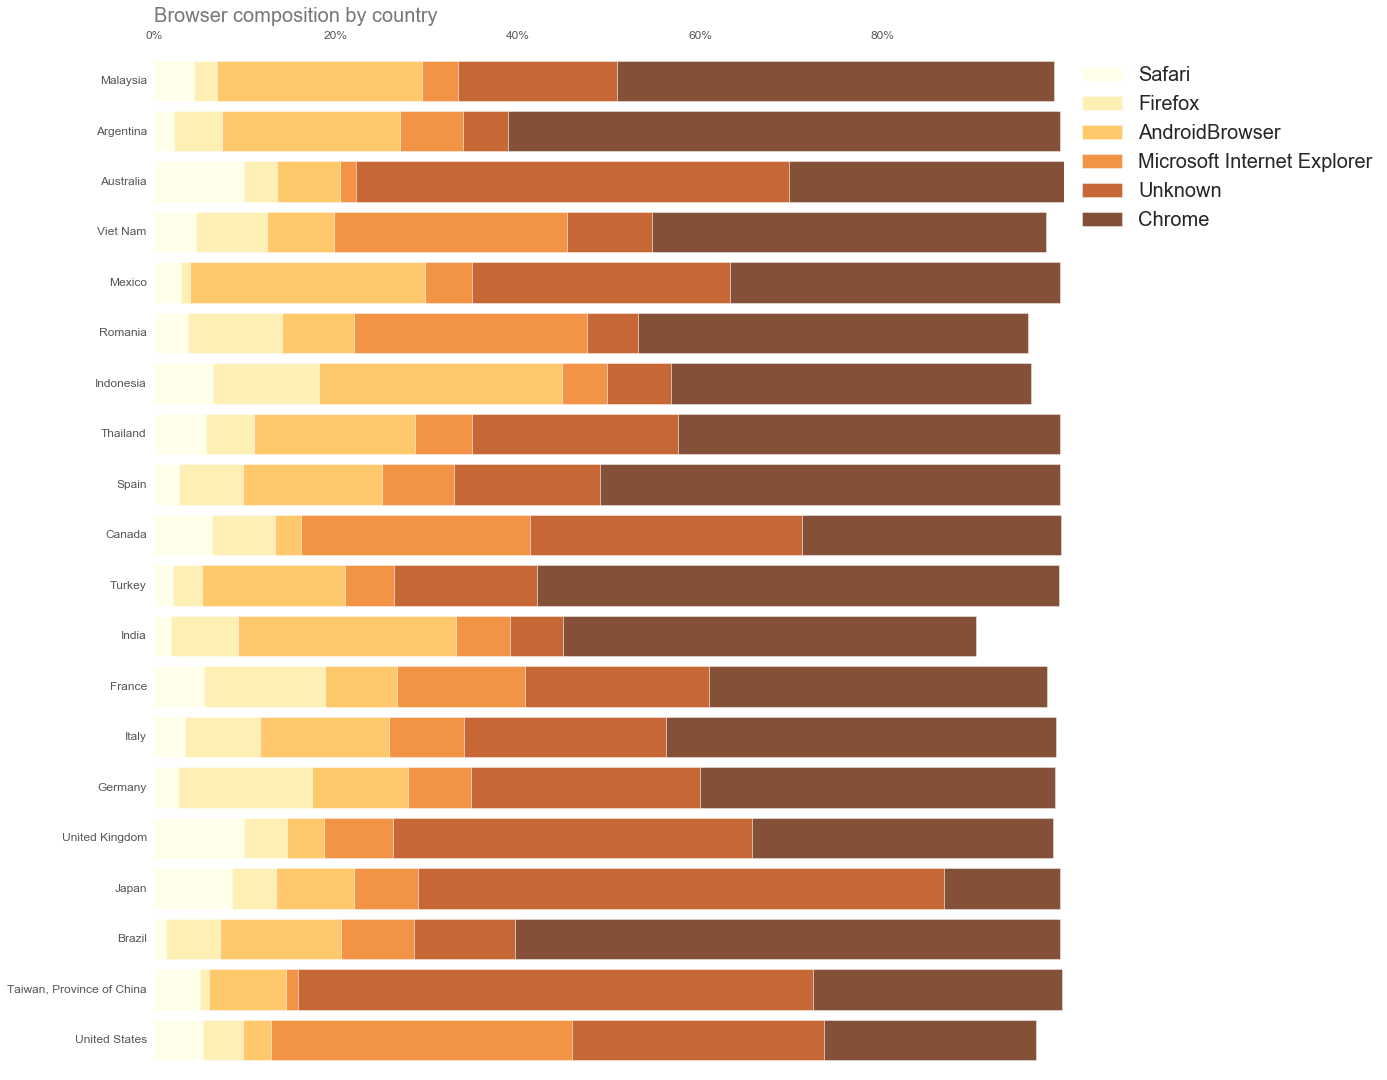

In [26]:
def plot_stacked_bar(df_to_plot, label, color_map = 'YlOrBr'):
    '''
    INPUT: DF, label(string) for the x-axis to be displayed at the top
    OUTPUT: Stacked Bar Chart
    '''
    # create a figure of given size
    fig = plt.figure(figsize=(15,15))

    # add a subplot
    ax = fig.add_subplot(111)

    # set color transparency (0: transparent; 1: solid)
    a = 0.8

    # set x axis label on top of plot, set label text
    xlab = label
    ax.set_xlabel(xlab, fontsize=20, alpha=a, ha='left')
    ax.xaxis.set_label_coords(0, 1.04)

    # position x tick labels on top
    ax.xaxis.tick_top()

    # remove tick lines in x and y axes
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    # remove grid lines (dotted lines inside plot)
    ax.grid(False)

    # Remove plot frame
    ax.set_frame_on(False)

    # using the actual data to plot
    df_to_plot[::-1].plot(
    ax=ax, 
    kind='barh', 
    alpha=a, 
    edgecolor='w',
    fontsize=12, 
    grid=True, 
    width=.8, 
    stacked=True,
    cmap=get_cmap(color_map)
    )


    # multiply xticks by format into pct
    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    xticks = matplotlib.ticker.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    ax.xaxis.set_ticks(ax.xaxis.get_majorticklocs()[:-1])

    plt.legend(prop={'size':20}, frameon=False, fancybox=None, loc="upper left", bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()
    ;


#limit to top 6 browsers
df_countries_stratified_by_browser_type_top_browsers = df_countries_stratified_by_browser_type[top_6_browsers] 

# limit to the to the top 20 countries
df_countries_stratified_by_browser_type_top_browsers_country = df_countries_stratified_by_browser_type_top_browsers.ix[top_x_countries]

# convert names of countries
df_countries_stratified_by_browser_type_top_browsers_country = convert_country_codes_index(df_countries_stratified_by_browser_type_top_browsers_country)

#limit to top 5 countries and top 6 browsers + misc browsers
plot_stacked_bar(df_countries_stratified_by_browser_type_top_browsers_country * 100, 'Browser composition by country')

#*note the gaps in the barchart are made because we're only limited to the top 6 browsers so not everythign sums to 100%

## Known and Unknown Browsers

Stripping the 'Uknown' browser types we quickly see most of the Unknown's are still coming from the US but larger proportion are coming from abroad though India and few others have slipped off the charts. That is, their UA strings must be easier to parse. 

In [27]:
#slide out 'unknown' and use it as a test set
df_feature_M_prediction_set = df_feature_M[df_feature_M.browser_type == 'Unknown']
df_feature_M_training_set = df_feature_M[df_feature_M.browser_type != 'Unknown']

0.878919383845
0.763577974255


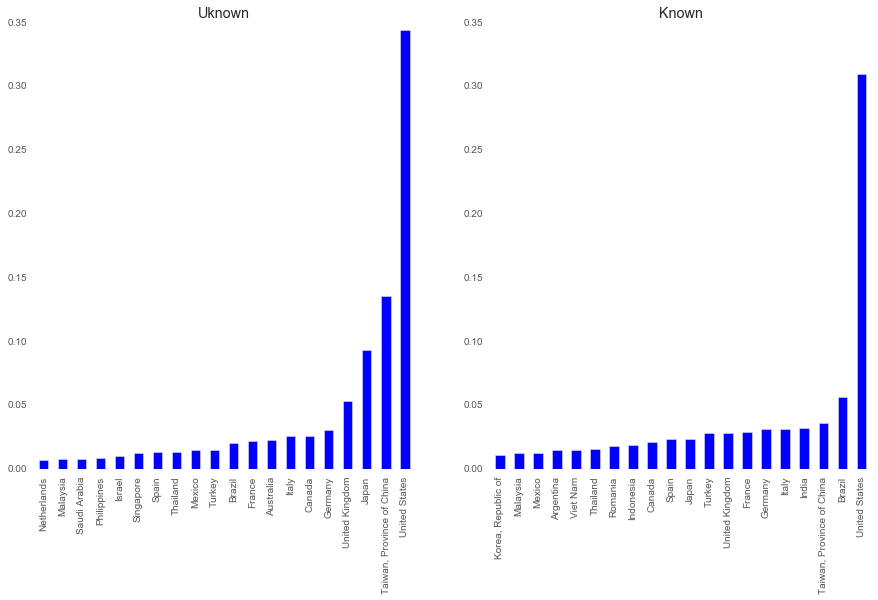

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 8))
top_x = 20
unknown_bar_c = df_feature_M_prediction_set['country_(two-letter_code)'].value_counts(1)[:top_x][::-1]
unknown_bar_c_encoded = convert_country_codes_index(unknown_bar_c)
unknown_bar_c_encoded.plot(kind='bar', ax=axes[0], title='Uknown')
print unknown_bar_c_encoded.sum()

top_x = 20
known_bar_c = df_feature_M_training_set['country_(two-letter_code)'].value_counts(1)[:top_x][::-1]
known_bar_c_encoded = convert_country_codes_index(known_bar_c)
known_bar_c_encoded.plot(kind='bar', ax=axes[1], title='Known')
print known_bar_c_encoded.sum()

These are the countries with an unknown browser type

In [29]:
#test/train split
df_feature_M_ = df_feature_M_training_set.drop(drop_of_interest, axis=1).dropna()
labels = df_feature_M_.pop('browser_type')
feature_m = df_feature_M_

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

#test_train split
x_train, x_hold_out, encoded_y_train, encoded_y_hold_out = train_test_split(
        feature_m, 
        encoded_labels, 
        test_size=.20, 
        random_state=42
)

In [30]:
xgb = XGBClassifier(
    max_depth=1,
    learning_rate=1,
    n_estimators=1,
    objective="multi:softprob",
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    nthread=-1,
    seed=42
)

#this is done to hold the training/tuning fixed
kf = KFold(len(x_train), n_folds=10, random_state=42)

In [31]:
#ndcg
xgb_ndcg_scores = cross_val_score(xgb, x_train, encoded_y_train, cv=kf, scoring=ndcg_scorer)

In [32]:
print np.mean(xgb_ndcg_scores), np.median(xgb_ndcg_scores), np.std(xgb_ndcg_scores)

0.754834899429 0.759123396191 0.00910915485055


##Scoring Metric
Usually when the class distribution is unbalanced, accuracy is considered a poor choice as it gives high scores to models which just predict the most frequent class.

*Note -- I still need to implement ROC AUC for multilabel. I believe it'll be a better metric for evaluation since it's not threshold sensitive.

In [33]:

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

#macro is better than micro in this case due to the 
f1_score = make_scorer(
            score_func=f1_score,
            pos_label=1,
            greater_is_better=True,
            average='weighted'
           )

xgb_macro_scores = cross_val_score(xgb, x_train, encoded_y_train, cv=kf, scoring=f1_score)
print np.mean(xgb_macro_scores), np.median(xgb_macro_scores), np.std(xgb_macro_scores)

0.436824222643 0.438286649257 0.00841420453808


In [34]:
clf = XGBClassifier(
    max_depth=1,
    learning_rate=1,
    n_estimators=1,
    objective="multi:softprob",
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    nthread=-1,
    seed=42
)

def multithread_map(fn, work_list, num_workers=50):
    from futures import ThreadPoolExecutor
    '''
    spawns a threadpool and assigns num_workers to some 
    list, array, or any other container. Motivation behind 
    this was for functions that involve scraping.
    '''
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        return list(executor.map(fn, work_list))


def get_scores(args):
    
    #done this way to support the map function within the threadpool
    clf, x_train, encoded_y_train = args 
    
    #this is done to hold the training/tuning fixed
    kf = KFold(len(x_train), n_folds=10, random_state=42)

    #grabbing scores
    scores = cross_val_score(
                            clf, 
                            x_train, 
                            encoded_y_train, 
                            cv=kf, 
                            
                            #put in arg to change this
                            scoring=f1_score
                    )
    return np.mean(scores), x_train.shape[0]

def get_optimal_number_of_training_examples(clf, x_train, y_train, number_of_steps=100, step_size=100, multithread=False):

    if multithread:
        #rename i to curr_step
        work_list = [(clf, x_train[step_size * i:], encoded_y_train[step_size * i:]) for i in range(number_of_steps)]
        score_keeper = multithread_map(get_scores, work_list)
    else:
        #simple way to do it
        score_keeper = []
        for i in range(number_of_steps):
            number_of_examples_to_trim_off = step_size * i
            score_keeper.append(
                get_scores((
                    clf, x_train[number_of_examples_to_trim_off:], 
                    encoded_y_train[number_of_examples_to_trim_off:]
                ))
            )

    
    df = pd.DataFrame(score_keeper).set_index(1)
    df.sort_index().rename(columns={0:'performance',1:'number_of_examples'}).plot()

    

##What's the correct training set size?

Another key component of this problem is trying to figure out the proper size for the training sets. This is a big issue when you're dealing with problems with massive datasets. We could be naively dismissive and assume all the data is worth training on but it's not quite that simple. 

There's diminishing returns at a certain point and it's ideal to figure out where that point is. A side benefit to this exercise is also viewing the stability of a model as you add batches of new examples.

As we can see with Logistic Regression, we've clearly got more room to run. For XGB, we see a plateau at around 50000-52000 examples indicating we've maximized the number of examples for this particular model. This finding only speaks for this particular model and feature matrix. This graph could totally change if we did feature engineering or gridsearching.

Note: the best practice way to do this is to sample examples randomly as opposed to adding them sequentially. (another fix for another iteration)

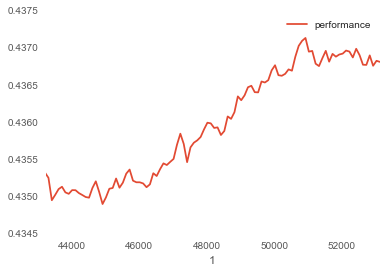

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

get_optimal_number_of_training_examples(xgb, x_train, encoded_y_train, multithread=True)

Logistic Regression seems to fair better not only in terms of raw performance but it's also showing more room for growth. This is pretty interesting considering XGB is considered to be one of the best classifiers in modern day machine learning.

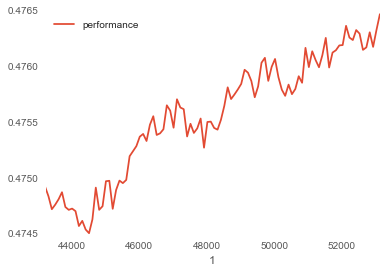

In [36]:
get_optimal_number_of_training_examples(LogisticRegression(),  x_train, encoded_y_train, multithread=True)

In [37]:
#fitting on entire set of data
clf.fit(feature_m, encoded_labels)

X_unknown_browsers = df_feature_M_prediction_set.drop(drop_of_interest + ['browser_type'], axis=1).dropna()
y_pred = clf.predict(X_unknown_browsers)

y_pred

array([1, 1, 1, ..., 1, 1, 1])